# Individual Data Plots

In [1]:
import numpy as np
import xarray as xr
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
from scipy import stats
import csv

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']

colors = prop_cycle.by_key()['color']
cc = prop_cycle.by_key()['color']

In [2]:
brokers = ['', '172.19.0.2', '172.19.0.3','172.19.0.4','172.19.0.5','172.19.0.6','172.19.0.7','172.19.0.8']
clients = ['172.19.0.9', '172.19.0.10']

filename = "../b1.csv"
csv_dir = "../../grand_heat_map/SPR_4-4/OI_1-7/linear_sf/csv/"
num_brokers = 7
csv_files = []
plot_base_name = ""
output_dir = "./"

In [3]:
def save_plot(file_name):
    global output_dir
    plt.savefig(output_dir + file_name + ".png", dpi=300)
    return

In [4]:
def my_init(csv_dir):
    csv_files = []
    # configures csv_files
    for i in range(num_brokers):
        file = csv_dir+"b{}.csv".format(i+1)
        # print(file)
        csv_files.append(file)
    return csv_files

def parse_single_csv(filename):
    fields = []
    rows = []

    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting field names through first row
        fields = next(csvreader)

        for row in csvreader:
            rows.append({ 'time': float(row[0]), 'len': int(row[1]), 'src': row[2], 'dst': row[3] })
        print("[{}] Total no. of rows: {}".format(filename, csvreader.line_num))

    # printing the field names


    #  printing first 5 rows
    # print('\nFirst 5 rows are:\n')
    # print(' | '.join(field.ljust(20) for field in fields))
    # for row in rows[:5]:
        # parsing each column of a row
        # print(' | '.join(str(col).ljust(20) for col in row.values()))
    return (fields, rows)

# returns a list of [ (field, data), (field, data) ]  for each csv in @csv_files
def parse_num_csv(csv_files):
    result = []
    for file in csv_files:
        # print("parsing "+file)
        result.append(parse_single_csv(file))
    return result

In [5]:
def print_csv(field, data, all_data = 1):
    print(' | '.join(field.ljust(20) for field in fields))
    if(all_data):
        for row in data:
            print(' | '.join(str(col).ljust(20) for col in row.values()))
        return
    if(all_data > len(data)):
        all_data = len(data)
    
    for row in data[:all_data]:
            print(' | '.join(str(col).ljust(20) for col in row.values()))
    return

def print_data(data, all_data = 1):
    if(all_data):
        all_data = len(data)
    if(all_data > len(data)):
        all_data = len(data)
    
    for row in data[:all_data]:
            print(' | '.join(str(col).ljust(20) for col in row.values()))
    return

# returns true if @src matches ANY of the @filters
def check_in_multiple(src, filters):
    if(filters is None or len(filters) == 0):
        print("[ DEBUG ] not filters passed in")
        return False
    
    if(isinstance(src, str) and not src.strip()):
        return True
    
    for filter in filters:
        if(src == filter):
            # print("[ DEBUG ] {} matches {}".format(src, filter))
            return True
    return False

# filters data by excluding rows that matches @src_ip and @dst_ip
def my_filter(data, src_ip_filter, dst_ip_filter):
    filtered = []
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return
    for row in data:
        condition_1 = check_in_multiple(row['src'], src_ip_filter)
        condition_2 = not check_in_multiple(row['dst'], dst_ip_filter)
        if(condition_1 and condition_2):
            filtered.append(row)
    return filtered

def round_time(data):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    result = []
    for row in data:
        clone = row.copy()
        clone['time'] = int(clone['time'])
        result.append(clone)

    # print_data(result)
    return result

# for all data with same data[@key], do agg_func(@data[@value])
# this assumes the data is ALREADY SORTED in data[@key]
def aggregate_dup(data, key='time', value='len', agg_func=None):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    if(not agg_func):
        agg_func = sum
    
    result = []
    temp = []
    curr_time = data[0][key]
    temp.append(data[0][value])
    
    for row in data[1:]:
        if(row[key] == curr_time):
            temp.append(row[value])
        else:
            # now we are at a new time, first compute the previous aggregates
            result.append({ 'time':curr_time, 'len': agg_func(temp) })
            # print("[ DEBUG ] summed to "+str({ 'rounded_time':curr_time, 'len': sum(temp) }))
            
            # reset the temp and update the new curr time pointer
            temp = []
            curr_time = row[key]
            temp.append(row[value])
    
    # computes the last
    result.append({ 'time':curr_time, 'len': agg_func(temp) })
    # print("[ DEBUG ] summed to "+str({ 'rounded_time':curr_time, 'len': agg_func(temp) }))
    return result

# works if @data is already sorted in key
def zero_fill(data, key='time', up_to = 125):
    result = []
    prev = data[0][key]
    if(prev > 0):
        # we need to pad backward in time
        missing = prev
        for i in range(missing):
                temp = data[0].copy()
                temp = dict.fromkeys(temp, 0)
                temp[key] = i
                result.append(temp)
    
    result.append(data[0])
    
    for curr in data[1:]:
        missing = curr[key] - prev - 1
        if(missing > 0):
            # not continous, zero fill
            for i in range(missing):
                temp = curr.copy()
                temp = dict.fromkeys(temp, 0)
                temp[key] = prev + i + 1
                result.append(temp)
        # nothing is missing
        result.append(curr)
        prev = curr[key]
    
    
    # zero fills for alignment
    if(prev < up_to):
        missing = up_to - prev
        for i in range(missing):
                temp = data[0].copy()
                temp = dict.fromkeys(temp, 0)
                temp[key] = prev + i + 1
                result.append(temp)
    
    return result

def cumulative_value(data, value='len'):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    result = []
    result.append(data[0])
    prev = data[0]
    for row in data[1:]:
        temp = row.copy()
        temp[value] += prev[value]
        result.append(temp)
        
        prev = temp
        
    return result

def split_into_x_y(data, key='time', value='len'):
    if data is None or len(data) == 0:
        print("[ ERROR ] no data given")
        return None
    x = []
    y = []
    for row in data:
        x.append(row[key])
        y.append(row[value])
    return (x,y)

In [6]:
def process_single(fields, rows, broker_num):
    src_filter = [brokers[broker_num]]
    dst_filter = clients
    # process data
    result = my_filter(rows, src_filter, dst_filter)
    result = round_time(result)
    result = aggregate_dup(result)
    result = zero_fill(result)
    result_cumu = cumulative_value(result)
    # converts to plottable format
    rate_x, rate_y = split_into_x_y(result)
    cumu_x, cumu_y = split_into_x_y(result_cumu)
    return (rate_x, rate_y, cumu_x, cumu_y)

# returns a list of [ (rate_x, rate_y, cumu_x, cumu_y) ]  for each data of type (field, data) in @all_data
def process_all(all_data, num_brokers):
    result = []
    for i in range(num_brokers):
        fld, data = all_data[i]
        result.append(process_single(fld, data, i+1))
    return result

In [7]:
def plot_single_rate(rate_x, rate_y, p_label='b1'):
    plt.plot(rate_x, rate_y, label = p_label);
    return

def plot_single_cumu(cumu_x, cumu_y):
    plt.stackplot(cumu_x, cumu_y);
    return

def plot_all_rate(all_data):
    global plot_base_name
    count = 1;
    for data in all_data:
        (rate_x, rate_y, cumu_x, cumu_y) = data
        plot_single_rate(rate_x, rate_y, p_label='b{}'.format(count));
        count += 1
    
    plt.xlabel('time (second)')
    plt.ylabel('Bytes Sent Per Second (byte)')
    plt.title("{} Rate Plot".format(plot_base_name))
    plt.legend();
    return

def plot_all_cumu(all_data):
    global plot_base_name
    count = 1;
    labels = []
    y_values = []
    for data in all_data:
        label = 'b{}'.format(count)
        labels.append(label)
        (rate_x, rate_y, cumu_x, cumu_y) = data
        y_values.append(cumu_y)
        count += 1
        
    # print(cumu_x, y_values[1], len(y_values[1]))
    plt.stackplot(cumu_x, y_values, labels=labels);
    
    plt.xlabel('time (second)')
    plt.ylabel('Cumulative Bytes Sent Per Second (byte)')
    plt.title("{} Cumulative Rate Plot".format(plot_base_name))
    plt.legend();
    return   


In [8]:
csv_dir = "../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/"
csv_files= my_init(csv_dir)
all_data = parse_num_csv(csv_files)
all_plot_data = process_all(all_data, num_brokers)

[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b1.csv] Total no. of rows: 578
[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b2.csv] Total no. of rows: 9
[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b3.csv] Total no. of rows: 24
[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b4.csv] Total no. of rows: 28
[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b5.csv] Total no. of rows: 20
[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b6.csv] Total no. of rows: 35
[../../grand_heat_map/SPR_0-6/OI_1-7/linear_sf/csv/b7.csv] Total no. of rows: 20


In [9]:
(rate_x, rate_y, cumu_x, cumu_y) = all_plot_data[0]
(rate_x_2, rate_y_2, cumu_x_2, cumu_y_2) = all_plot_data[1]

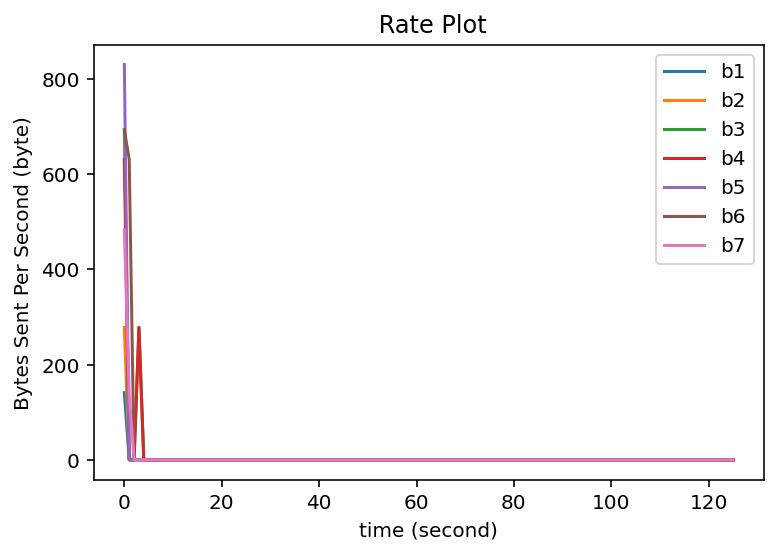

In [10]:
plot_all_rate(all_plot_data)

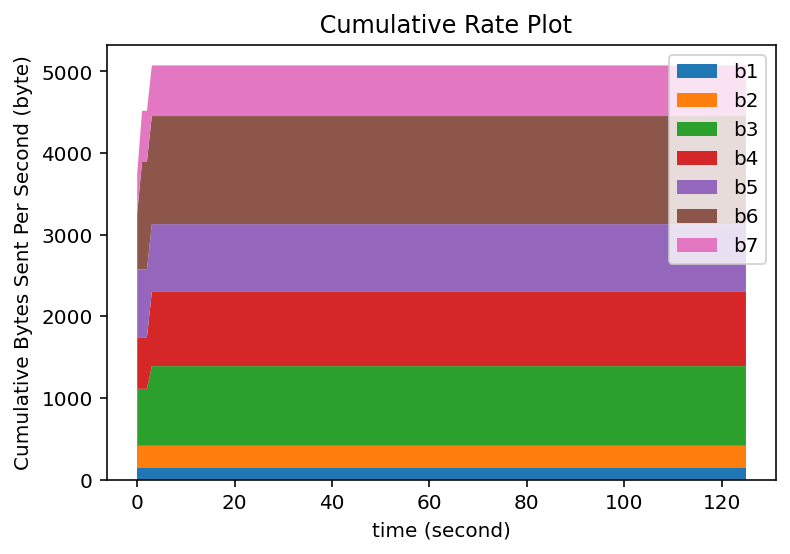

In [11]:
plot_all_cumu(all_plot_data)

# Heat Map Computation

> Note:
> - this section needs the previous section to be ran once

In [12]:
# contains a list of processed [ (rate_x, rate_y, cumu_x, cumu_y) ]
all_plot_data[6][-1][-1] #gets the cumulative count of broker 7's cumulative data's last entry

620

In [13]:
# computes the sum of last cumulative datas
def compute_cumu_total(all_plot_data):
    total = 0
    count = 1
    for broker in all_plot_data:
        print("[ LOG ] Summing broker{}".format(count))
        count+=1
        broker_cumu_total = broker[-1][-1]
        total += broker_cumu_total
    return total

In [14]:
compute_cumu_total(all_plot_data)

[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7


5073

In [15]:
# computes the ratio of total_sf/total_pf
# e.g. @csv_dir_pf = "../THR_7-7/OI_7-7/linear_pf/csv/"
def compute_single_sub_pub_diff(csv_dir_sf, csv_dir_pf):
    global csv_dir
    # first computes sum of lasts for sf
    csv_dir = csv_dir_sf
    csv_files= my_init(csv_dir)
    all_data = parse_num_csv(csv_files)
    all_plot_data = process_all(all_data, num_brokers)
    sf_total = compute_cumu_total(all_plot_data)
    print("[ LOG ] Computed sf total {}".format(sf_total))
    # then computes sum of lasts for pf
    csv_dir = csv_dir_pf
    csv_files= my_init(csv_dir)
    all_data = parse_num_csv(csv_files)
    all_plot_data = process_all(all_data, num_brokers)
    pf_total = compute_cumu_total(all_plot_data)
    print("[ LOG ] Computed pf total {}".format(pf_total))
    return float(sf_total)/pf_total

In [16]:
# demo
compute_single_sub_pub_diff("../THR_7-7/OI_7-7/linear_sf/csv/", "../THR_7-7/OI_7-7/linear_pf/csv/")
# this one has almost no differece
compute_single_sub_pub_diff("../THR_3-7/OI_1-7/linear_pf/csv/", "../THR_3-7/OI_3-7/linear_pf/csv/") 

[../THR_7-7/OI_7-7/linear_sf/csv/b1.csv] Total no. of rows: 6148
[../THR_7-7/OI_7-7/linear_sf/csv/b2.csv] Total no. of rows: 3686
[../THR_7-7/OI_7-7/linear_sf/csv/b3.csv] Total no. of rows: 3669
[../THR_7-7/OI_7-7/linear_sf/csv/b4.csv] Total no. of rows: 3641
[../THR_7-7/OI_7-7/linear_sf/csv/b5.csv] Total no. of rows: 3663
[../THR_7-7/OI_7-7/linear_sf/csv/b6.csv] Total no. of rows: 3686
[../THR_7-7/OI_7-7/linear_sf/csv/b7.csv] Total no. of rows: 3738
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 786381
[../THR_7-7/OI_7-7/linear_pf/csv/b1.csv] Total no. of rows: 7560
[../THR_7-7/OI_7-7/linear_pf/csv/b2.csv] Total no. of rows: 3592
[../THR_7-7/OI_7-7/linear_pf/csv/b3.csv] Total no. of rows: 3533
[../THR_7-7/OI_7-7/linear_pf/csv/b4.csv] Total no. of rows: 3505
[../THR_7-7/OI_7-7/linear_pf/csv/b5.csv] Total no. of rows: 3466
[../THR_7-7/OI_7-7/

0.9592204052247248

In [17]:
# for example, iterating over ../THR_7-7/OI_7-7/linear_sf/csv/ means @base_dir = "../"
def compute_all_csv_dir(base_dir):
    global all_csv_dir
    all_csv_dir = []
    # since I have 4*4 for heat map, I do iterate over 7,5,3,1
    # note I do it in reverse order because the heat_map [0][0] start with 7/7 data
    for i in range(7, 0, -2):
        sub_sf_dir = "OI_{}-7/linear_sf/csv/".format(i)
        sub_pf_dir = "OI_{}-7/linear_pf/csv/".format(i)
        fake_array = []
        all_csv_dir.append(fake_array)
        for j in range(7, 0, -2):
            # notice we are going horizontal first
            sf_dir = "{}THR_{}-7/{}".format(base_dir, j, sub_sf_dir)
            pf_dir = "{}THR_{}-7/{}".format(base_dir, j, sub_pf_dir)
            fake_array.append((sf_dir, pf_dir))
    return all_csv_dir

# for some experiments, since data are the same, they are skipped
# for example, all pf for THR_3-7 will the same
def lazy_exp(base_dir):
    global all_csv_dir
    # since I have 4*4 for heat map, I do iterate over 7,5,3,1
    # note I do it in reverse order because the heat_map [0][0] start with 7/7 data
    for i in range(2, 4, 1):
        parent_dir = "{}THR_{}-7/".format(base_dir, int(7-i*2))
        for j in range(0, 4, 1):
            csv_pf_dir = "{}OI_3-7/linear_pf/csv/".format(parent_dir)
            original_sf = all_csv_dir[j][i][0]
            all_csv_dir[j][i] = (original_sf, csv_pf_dir)
    return all_csv_dir

In [18]:
all_csv_dir = []
# computes all the csv_directories into a matrix
compute_all_csv_dir("../")
lazy_exp("../")

[[('../THR_7-7/OI_7-7/linear_sf/csv/', '../THR_7-7/OI_7-7/linear_pf/csv/'),
  ('../THR_5-7/OI_7-7/linear_sf/csv/', '../THR_5-7/OI_7-7/linear_pf/csv/'),
  ('../THR_3-7/OI_7-7/linear_sf/csv/', '../THR_3-7/OI_3-7/linear_pf/csv/'),
  ('../THR_1-7/OI_7-7/linear_sf/csv/', '../THR_1-7/OI_3-7/linear_pf/csv/')],
 [('../THR_7-7/OI_5-7/linear_sf/csv/', '../THR_7-7/OI_5-7/linear_pf/csv/'),
  ('../THR_5-7/OI_5-7/linear_sf/csv/', '../THR_5-7/OI_5-7/linear_pf/csv/'),
  ('../THR_3-7/OI_5-7/linear_sf/csv/', '../THR_3-7/OI_3-7/linear_pf/csv/'),
  ('../THR_1-7/OI_5-7/linear_sf/csv/', '../THR_1-7/OI_3-7/linear_pf/csv/')],
 [('../THR_7-7/OI_3-7/linear_sf/csv/', '../THR_7-7/OI_3-7/linear_pf/csv/'),
  ('../THR_5-7/OI_3-7/linear_sf/csv/', '../THR_5-7/OI_3-7/linear_pf/csv/'),
  ('../THR_3-7/OI_3-7/linear_sf/csv/', '../THR_3-7/OI_3-7/linear_pf/csv/'),
  ('../THR_1-7/OI_3-7/linear_sf/csv/', '../THR_1-7/OI_3-7/linear_pf/csv/')],
 [('../THR_7-7/OI_1-7/linear_sf/csv/', '../THR_7-7/OI_1-7/linear_pf/csv/'),
  ('../TH

In [19]:
def compute_heat_map(all_csv_dir):
    hori = len(all_csv_dir[0])
    vert = len(all_csv_dir)
    heat_map = np.zeros((vert, hori))
    for i in range(vert):
        for j in range(hori):
            sf_dir, pf_dir = all_csv_dir[i][j]
            heat_map[i][j] = compute_single_sub_pub_diff(sf_dir, pf_dir)
    return heat_map    

In [20]:
heat_map = compute_heat_map(all_csv_dir)

[../THR_7-7/OI_7-7/linear_sf/csv/b1.csv] Total no. of rows: 6148
[../THR_7-7/OI_7-7/linear_sf/csv/b2.csv] Total no. of rows: 3686
[../THR_7-7/OI_7-7/linear_sf/csv/b3.csv] Total no. of rows: 3669
[../THR_7-7/OI_7-7/linear_sf/csv/b4.csv] Total no. of rows: 3641
[../THR_7-7/OI_7-7/linear_sf/csv/b5.csv] Total no. of rows: 3663
[../THR_7-7/OI_7-7/linear_sf/csv/b6.csv] Total no. of rows: 3686
[../THR_7-7/OI_7-7/linear_sf/csv/b7.csv] Total no. of rows: 3738
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 786381
[../THR_7-7/OI_7-7/linear_pf/csv/b1.csv] Total no. of rows: 7560
[../THR_7-7/OI_7-7/linear_pf/csv/b2.csv] Total no. of rows: 3592
[../THR_7-7/OI_7-7/linear_pf/csv/b3.csv] Total no. of rows: 3533
[../THR_7-7/OI_7-7/linear_pf/csv/b4.csv] Total no. of rows: 3505
[../THR_7-7/OI_7-7/linear_pf/csv/b5.csv] Total no. of rows: 3466
[../THR_7-7/OI_7-7/

[../THR_1-7/OI_5-7/linear_sf/csv/b3.csv] Total no. of rows: 648
[../THR_1-7/OI_5-7/linear_sf/csv/b4.csv] Total no. of rows: 656
[../THR_1-7/OI_5-7/linear_sf/csv/b5.csv] Total no. of rows: 684
[../THR_1-7/OI_5-7/linear_sf/csv/b6.csv] Total no. of rows: 72
[../THR_1-7/OI_5-7/linear_sf/csv/b7.csv] Total no. of rows: 44
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 97416
[../THR_1-7/OI_3-7/linear_pf/csv/b1.csv] Total no. of rows: 911
[../THR_1-7/OI_3-7/linear_pf/csv/b2.csv] Total no. of rows: 603
[../THR_1-7/OI_3-7/linear_pf/csv/b3.csv] Total no. of rows: 916
[../THR_1-7/OI_3-7/linear_pf/csv/b4.csv] Total no. of rows: 601
[../THR_1-7/OI_3-7/linear_pf/csv/b5.csv] Total no. of rows: 601
[../THR_1-7/OI_3-7/linear_pf/csv/b6.csv] Total no. of rows: 602
[../THR_1-7/OI_3-7/linear_pf/csv/b7.csv] Total no. of rows: 302
[ LOG ] Summing broker1
[ LOG ] Su

[../THR_5-7/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 2533
[../THR_5-7/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 1284
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed pf total 538446
[../THR_3-7/OI_1-7/linear_sf/csv/b1.csv] Total no. of rows: 2704
[../THR_3-7/OI_1-7/linear_sf/csv/b2.csv] Total no. of rows: 41
[../THR_3-7/OI_1-7/linear_sf/csv/b3.csv] Total no. of rows: 41
[../THR_3-7/OI_1-7/linear_sf/csv/b4.csv] Total no. of rows: 40
[../THR_3-7/OI_1-7/linear_sf/csv/b5.csv] Total no. of rows: 43
[../THR_3-7/OI_1-7/linear_sf/csv/b6.csv] Total no. of rows: 45
[../THR_3-7/OI_1-7/linear_sf/csv/b7.csv] Total no. of rows: 23
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 7122
[../THR_3-7/OI_3-7/linear_p

In [21]:
# compute_single_sub_pub_diff("../THR_3-7/OI_5-7/linear_sf/csv/", "../THR_3-7/OI_5-7/linear_pf/csv/")

In [22]:
def heat_map_plot(data_matrix, x_axis, y_axis, plot_title="", char_label="SF Total / PF Total"):
    plt.clf()
    fig, ax = plt.subplots()
    im = ax.imshow(data_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(char_label, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(x_axis)))
    ax.set_yticks(np.arange(len(y_axis)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_axis)
    ax.set_yticklabels(y_axis)
    
    plt.title("{}".format(plot_title))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(x_axis)):
        for j in range(len(y_axis)):
            text = ax.text(j, i, "{:.2f}".format(data_matrix[i, j]),
                           ha="center", va="center", color="black")
    return fig

<Figure size 432x288 with 0 Axes>

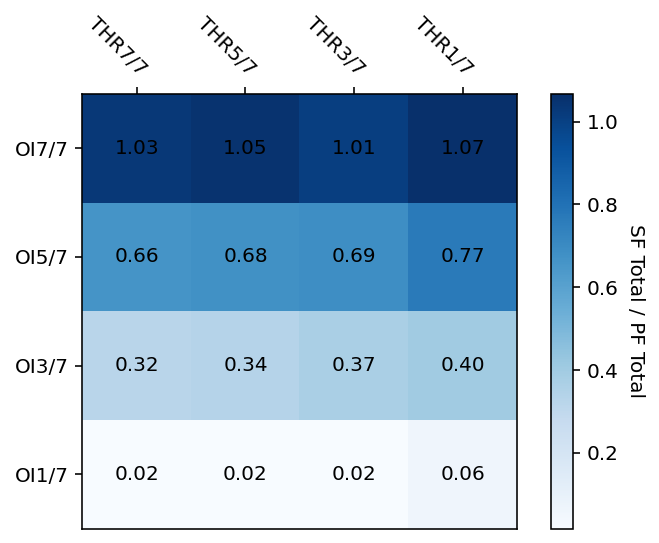

In [23]:
heat_x_axis = ["OI7/7", "OI5/7", "OI3/7", "OI1/7"]
heat_y_axis =  ["THR7/7", "THR5/7", "THR3/7", "THR1/7"]

fig = heat_map_plot(heat_map, heat_y_axis, heat_x_axis)
# saves figure but not axis
# fig.savefig('./heat_map.png', dpi=300)

## Heat Map Model
this uses the model I developed and written down in the tex/markdown file

[0][0] -> OI=1.0 THR=0.01
[0][1] -> OI=1.0 THR=0.013999999999999999
[0][2] -> OI=1.0 THR=0.023333333333333334
[0][3] -> OI=1.0 THR=0.07
[1][0] -> OI=0.6666666666666666 THR=0.01
[1][1] -> OI=0.6666666666666666 THR=0.013999999999999999
[1][2] -> OI=0.6666666666666666 THR=0.023333333333333334
[1][3] -> OI=0.6666666666666666 THR=0.07
[2][0] -> OI=0.3333333333333333 THR=0.01
[2][1] -> OI=0.3333333333333333 THR=0.013999999999999999
[2][2] -> OI=0.3333333333333333 THR=0.023333333333333334
[2][3] -> OI=0.3333333333333333 THR=0.07
[3][0] -> OI=0.0 THR=0.01
[3][1] -> OI=0.0 THR=0.013999999999999999
[3][2] -> OI=0.0 THR=0.023333333333333334
[3][3] -> OI=0.0 THR=0.07


<Figure size 432x288 with 0 Axes>

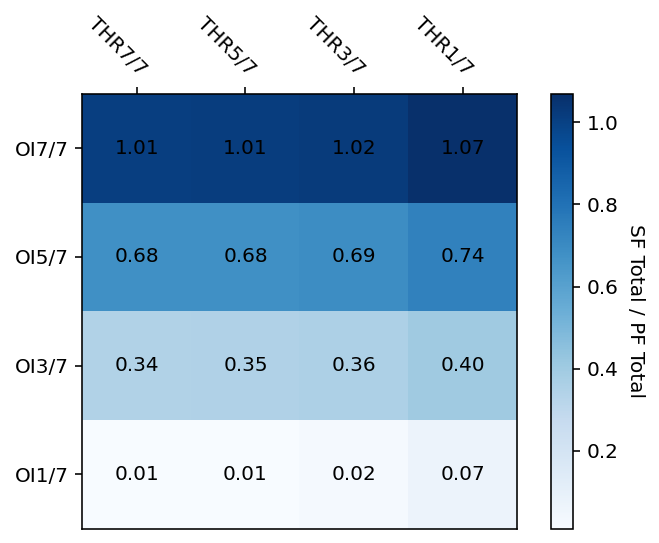

In [24]:
hm_ratio = []
hm_prediction = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        THR = float(7-2*j)/float(7)
        OI_term = float(6-2*i)/float(7-1)
        THR_term = (1.0/100.0) * (1.0/(THR))
        print("[{}][{}] -> OI={} THR={}".format(i,j,OI_term, THR_term))
        hm_prediction[i][j] = OI_term + THR_term
fig = heat_map_plot(hm_prediction, heat_y_axis, heat_x_axis)
# saves figure
# fig.savefig('./heat_map_prediction.png', dpi=300)

# Grand Heat Map

In [25]:
compute_single_sub_pub_diff("../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/", "../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/")
# this one has almost no differece

[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 755
[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b2.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b3.csv] Total no. of rows: 366
[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b4.csv] Total no. of rows: 366
[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b5.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_4-6/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 184
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 77394
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 753
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b2.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b3.csv] Tot

0.9992253466573708

In [26]:
# for example, iterating over ../THR_7-7/OI_7-7/linear_sf/csv/ means @base_dir = "../"
def grand_compute_all_csv_dir(base_dir, first_level_name, second_level_name):
    global grand_all_csv_dir
    grand_all_csv_dir = []
    # since I have 4*4 for heat map, I do iterate over 7,5,3,1
    # note I do it in reverse order because the heat_map [0][0] start with 7/7 data
    for i in range(1, 8, 2):
        sub_sf_dir = "{}_{}-7/linear_sf/csv/".format(second_level_name, i)
        sub_pf_dir = "{}_{}-7/linear_pf/csv/".format(second_level_name, i)
        fake_array = []
        grand_all_csv_dir.append(fake_array)
        for j in range(6, -1, -2):
            # notice we are going horizontal first
            # e.g. {}SPR_{}-7/{OI_7-7/linear_sf/csv/}
            sf_dir = "{}{}_{}-6/{}".format(base_dir, first_level_name, j, sub_sf_dir)
            pf_dir = "{}{}_{}-6/{}".format(base_dir, first_level_name, j, sub_pf_dir)
            fake_array.append((sf_dir, pf_dir))
    return grand_all_csv_dir

# for some experiments, since data are the same, they are skipped
# for example, ALL pf are the same in this experiement, since I configured all to have 100 pub
def grand_lazy_exp(base_dir, first_level_name, second_level_name):
    global grand_all_csv_dir
    for i in range(0, 4, 1):
        for j in range(0, 4, 1):
            # notice we are going horizontal first
            # e.g. {}SPR_{}-7/{OI_7-7/linear_sf/csv/}
            original_sf = grand_all_csv_dir[i][j][0]
            fake_pf = pf_dir = "{}{}_6-6/{}_1-7/linear_pf/csv/".format(base_dir, first_level_name, second_level_name)
            grand_all_csv_dir[i][j] = (original_sf, fake_pf)
    return grand_all_csv_dir

In [27]:
grand_all_csv_dir = []
# computes all the csv_directories into a matrix
grand_all_csv_dir = grand_compute_all_csv_dir("../../grand_heat_map/", "SPR", "OI")
grand_all_csv_dir = grand_lazy_exp("../../grand_heat_map/","SPR", "OI")
# grand_all_csv_dir

In [28]:
grand_heat_map = compute_heat_map(grand_all_csv_dir)

[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b1.csv] Total no. of rows: 651
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b2.csv] Total no. of rows: 204
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b3.csv] Total no. of rows: 255
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b4.csv] Total no. of rows: 209
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b5.csv] Total no. of rows: 211
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b6.csv] Total no. of rows: 247
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_sf/csv/b7.csv] Total no. of rows: 119
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed sf total 48774
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 753
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b2.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b3.csv] Tot

[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b1.csv] Total no. of rows: 753
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b2.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b3.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b4.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b5.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 184
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed pf total 77454
[../../grand_heat_map/SPR_2-6/OI_3-7/linear_sf/csv/b1.csv] Total no. of rows: 598
[../../grand_heat_map/SPR_2-6/OI_3-7/linear_sf/csv/b2.csv] Total no. of rows: 429
[../../grand_heat_map/SPR_2-6/OI_3-7/linear_sf/csv/b3.csv] Tot

[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b3.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b4.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b5.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b6.csv] Total no. of rows: 367
[../../grand_heat_map/SPR_6-6/OI_1-7/linear_pf/csv/b7.csv] Total no. of rows: 184
[ LOG ] Summing broker1
[ LOG ] Summing broker2
[ LOG ] Summing broker3
[ LOG ] Summing broker4
[ LOG ] Summing broker5
[ LOG ] Summing broker6
[ LOG ] Summing broker7
[ LOG ] Computed pf total 77454
[../../grand_heat_map/SPR_4-6/OI_7-7/linear_sf/csv/b1.csv] Total no. of rows: 628
[../../grand_heat_map/SPR_4-6/OI_7-7/linear_sf/csv/b2.csv] Total no. of rows: 492
[../../grand_heat_map/SPR_4-6/OI_7-7/linear_sf/csv/b3.csv] Total no. of rows: 492
[../../grand_heat_map/SPR_4-6/OI_7-7/linear_sf/csv/b4.csv] Total no. of rows: 507
[../../grand_heat_map/SPR_4-6/OI_7-7/linear_sf/csv/b5.csv] Tot

<Figure size 432x288 with 0 Axes>

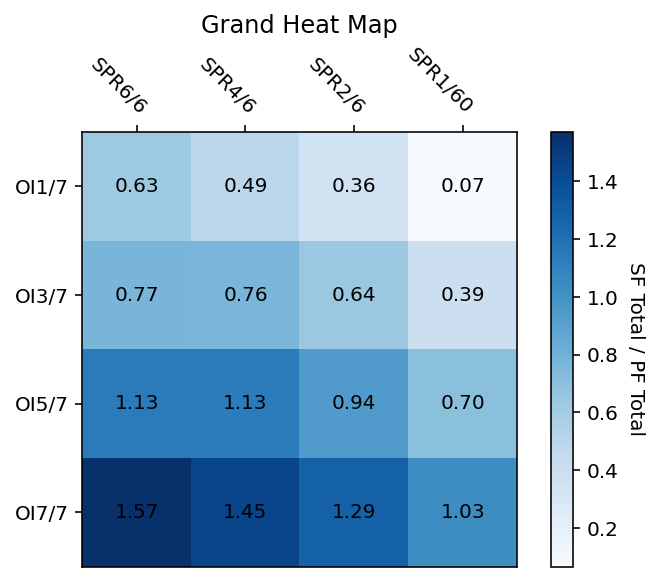

In [29]:
grand_heat_y_axis = ["OI1/7", "OI3/7", "OI5/7", "OI7/7"]
grand_heat_x_axis =  ["SPR6/6", "SPR4/6", "SPR2/6", "SPR1/60"]

fig = heat_map_plot(grand_heat_map, grand_heat_x_axis, grand_heat_y_axis, "Grand Heat Map")
# fig.savefig('./grand_heat_map.png', dpi=300)

It turns out that assuming $\frac{1}{2}$ probability of **subscribe + subback + tcp_ack collapsing** would be somewhat better than the raw prediction of
$$
\begin{align*}
\frac{\text{total sb} }{\text{total pb} }
    &= \frac{OI \cdot B_n - 1}{B_n - 1} +
    \frac{m_s \cdot s_t}{m_p \cdot p_t}  \to \frac{OI \cdot B_n - 1}{B_n - 1} +
    \frac{m_s \cdot s_t \cdot \frac{1}{2}}{m_p \cdot p_t}
.\end{align*}
$$

# Grand Heat Map Prediction


### Without 0.5 ratio fix

<Figure size 432x288 with 0 Axes>

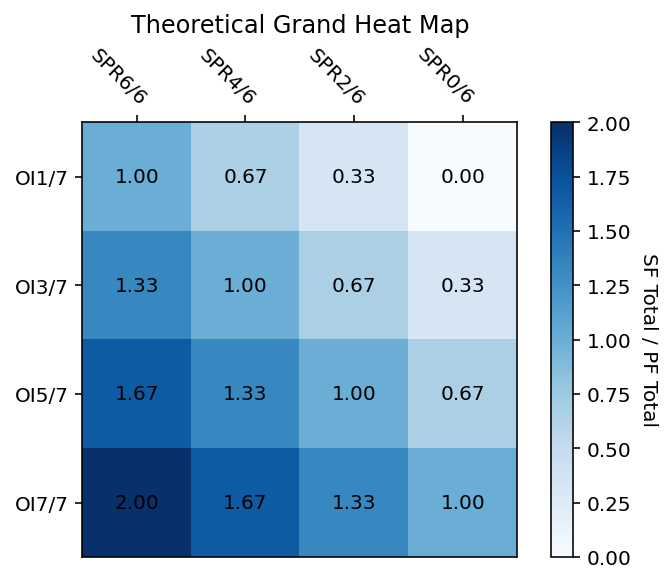

In [30]:
predict_grand_heat_x_axis =  ["SPR6/6", "SPR4/6", "SPR2/6", "SPR0/6"]
grand_hm_prediction = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        OI_term = (2.0*i)/float(7-1)
        SPR_term = (6-2*j)/6.0
        grand_hm_prediction[i][j] = OI_term + SPR_term
fig = heat_map_plot(grand_hm_prediction, predict_grand_heat_x_axis, grand_heat_y_axis, "Theoretical Grand Heat Map")
# saves figure
# fig.savefig('./grand_heat_map_prediction.png', dpi=300)

### With 0.5 ratio fix

<Figure size 432x288 with 0 Axes>

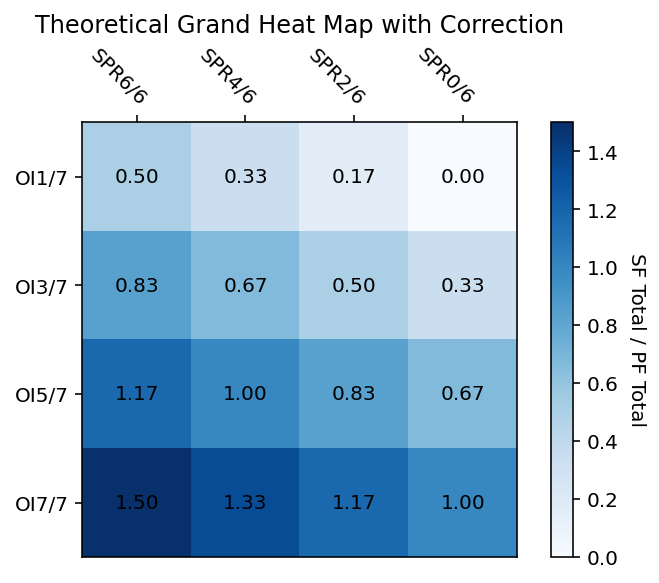

In [31]:
grand_hm_prediction_2 = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        OI_term = float(2*i)/float(7-1)
        SPR_term = (6-2*j)/6.0
        grand_hm_prediction_2[i][j] = OI_term + SPR_term * (0.5)
fig = heat_map_plot(grand_hm_prediction_2, predict_grand_heat_x_axis, grand_heat_y_axis, "Theoretical Grand Heat Map with Correction")
# saves figure
# fig.savefig('./grand_heat_map_prediction_with_correction.png', dpi=300)

### Without 0.5 fix and 1/60 instead of 0/6

<Figure size 432x288 with 0 Axes>

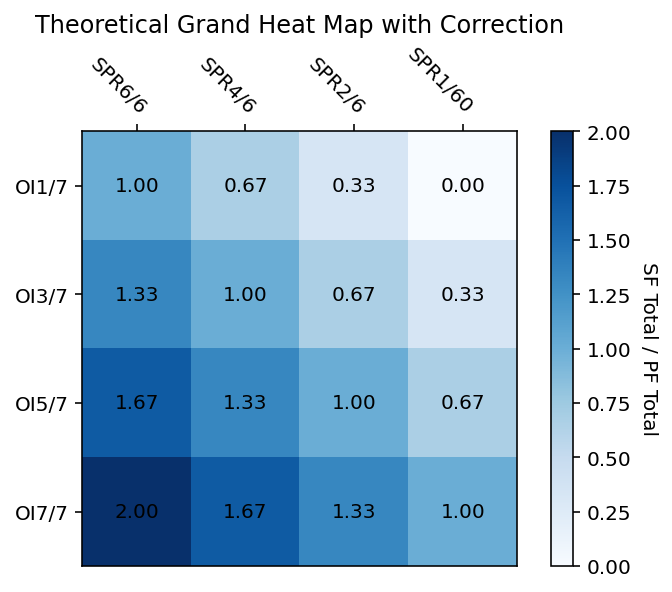

In [32]:
grand_hm_prediction_3 = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        if j == 4:
            SPR_term = (1)/60.0
        else:
            SPR_term = (6-2*j)/6.0
        OI_term = float(2*i)/float(7-1)
        grand_hm_prediction_3[i][j] = OI_term + SPR_term
fig = heat_map_plot(grand_hm_prediction_3, grand_heat_x_axis, grand_heat_y_axis, "Theoretical Grand Heat Map with Correction")
# saves figure
# fig.savefig('./grand_heat_map_prediction_exact_with_correction.png', dpi=300)

### Ratio Computation
- larger number means **larger collapse rate**

<Figure size 432x288 with 0 Axes>

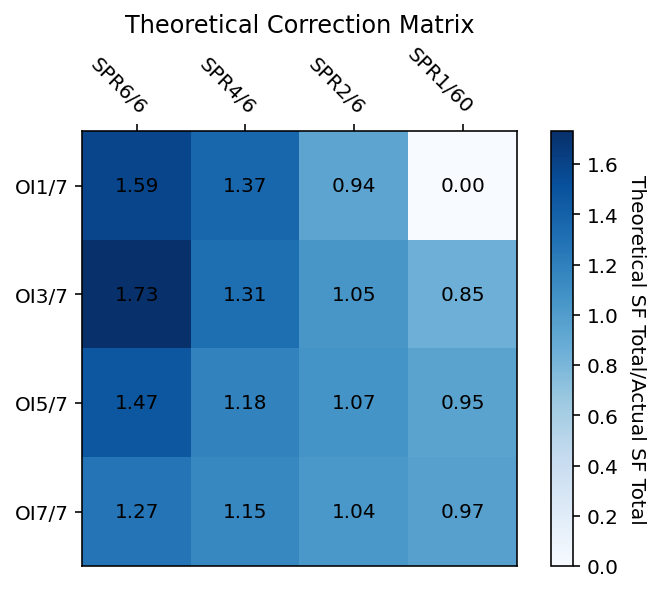

In [33]:
grand_hm_ratio = np.divide(grand_hm_prediction_3, grand_heat_map)

fig = heat_map_plot(grand_hm_ratio, grand_heat_x_axis, grand_heat_y_axis, 
                    "Theoretical Correction Matrix", "Theoretical SF Total/Actual SF Total")
# saves figure
# fig.savefig('./grand_heat_map_correction_matrix.png', dpi=300)

so we see that:
- the more broker it needs to send, the **more** the **publish** (including `TCP_ACK`) collapsing (minor)
- the more subscriber there are, the **more** the **subscribe** (including `TCP_ACK`) collapsing
    - in fact, another factor is: the less broker it sends, the **more** the **subscribe** (including `TCP_ACK`) collapsing

# Delay Graphs

In [34]:
# some related MQTT + tshark constants
mqtt_msgtype = { 1: "connect", 2: "connack", 
                3: "publish", 4: "pubback", 5: "pubrec", 6: "pubrel", 7: "pubcomp",
                8: "subscribe", 9: "subback"}

In [70]:
delay_csv_dir = "../../delay_graph/tc-0/linear_pf/csv/"
delay_files = my_init(delay_csv_dir)

In [109]:
def str_to_int_converter(field_data):
    if(field_data is None):
        return field_data
    parsed = field_data.split('^')
    result = []
    for data in parsed:
        result.append(int(data))
    return result

def mqtt_msgtype_converter(field_data):
    global mqtt_msgtype
    if(field_data is None):
        return field_data
    parsed = field_data.split('^')
    result = []
    for data in parsed:
        result.append((int(data), mqtt_msgtype.get(int(data))))
    return result
    
# applies some preprocessing to @field_data, and feed it to @converter function
def csv_field_converter(field_data, converter):
    if(field_data is None):
        return converter(field_data)
    elif(isinstance(field_data, str)):
        field_data.strip()
        if(field_data):
            return converter(field_data)
        else:
            return converter(None)
    else:
        return converter(field_data)
        
    
def parse_single_delay_csv(filename):
    fields = []
    rows = []

    with open(filename, 'r') as csvfile:
        # creating a csv reader object
        csvreader = csv.reader(csvfile)

        # extracting field names through first row
        fields = next(csvreader)

        for row in csvreader:
            rows.append({ 
                'time': float(row[0]), 
                'len': int(row[1]), 
                'src': row[2], 
                'dst': row[3],
                'msgtype':csv_field_converter(row[4], mqtt_msgtype_converter),
                'msgid':csv_field_converter(row[-1], str_to_int_converter)
            })
        needed_fields = [0,1,2,3,4,-1]
        fields = [fields[index] for index in needed_fields]

        print("[{}] Total no. of rows: {}".format(filename, csvreader.line_num))
    return (fields, rows)

# returns a list of [ (field, data), (field, data) ]  for each csv in @csv_files
def parse_num_delay_csv(csv_files):
    result = []
    for file in csv_files:
        # print("parsing "+file)
        result.append(parse_single_delay_csv(file))
    return result

In [110]:
f_tmp, r_tmp = parse_single_delay_csv(delay_files[0])

[../../delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 71301


In [111]:
"""
computes the correct time offset between src and dst, by looking at the time for CONNECT command
because tcpdump aligns time, so it appears that
    sub_connect at t=0 (approx)
    pub_connect at t=0 as well (approx)!
but in fact, I have configured pub_connect to be 5 seconds later
"""
def compute_src_dst_offset(src_raw, src_broker_num, dst_raw, dst_broker_num, exp_offset=5):
    src_data = my_delay_filter(src_raw, clients, clients, 1)
    if(src_data is None or len(src_data) == 0):
        print("[ ERROR ] no connect found for src_raw")
        return None
    dst_data = my_delay_filter(dst_raw, clients, clients, 1)
    if(dst_data is None or len(dst_data) == 0):
        print("[ ERROR ] no connect found for dst_raw")
        return None
    print("[ LOG ] offset between dst={} and src={}".format(dst_data[0]['time'], src_data[0]['time']))
    return exp_offset - (dst_data[0]['time'] - src_data[0]['time'])

In [313]:
# list version of check_in_multiple() function, where input @src could be list
def list_check_in_multiple(src, filters):
    if(filters is None or len(filters) == 0):
        print("[ DEBUG ] not filters passed in")
        return False
    
    if(src is None or len(src)==0):
        return False #don't want to match this time
    
    for data in src:
        if(check_in_multiple(data[0], filters)):
            # print("[ DEBUG ] {} matches {}".format(data[0], filter))
            return True
    return False

# filters data by excluding rows that matches @src_ip and @dst_ip
# assumes @msg_type is int
def my_delay_filter(data, src_ip_filter, dst_ip_filter, msg_type):
    filtered = []
    if(not isinstance(msg_type, list)):
        msg_type = [msg_type]
    
    if data is None or len(data) == 0:
        print("[ ERROR my_delay_filter ] no data given")
        return
    for row in data:
        condition_1 = check_in_multiple(row['src'], src_ip_filter)
        condition_2 = not check_in_multiple(row['dst'], dst_ip_filter)        
        condition_3 = list_check_in_multiple(row['msgtype'], msg_type)
        if(condition_1 and condition_2 and condition_3):
            filtered.append(row)
    return filtered

# process_single(f_tmp, r_tmp, 1)
# @is_src = 1 means we are interested in broker->broker data. Otherwise, broker->client data
def delay_process_single(fields, rows, broker_num, is_src = 1):
    src_filter = [brokers[broker_num]]
    # src_filter = clients if is_src else [brokers[broker_num]]
    dst_filter = clients if is_src else brokers[1:]
    # process data
    result = my_delay_filter(rows, src_filter, dst_filter, 3)
    return result

'''
@all_data: consists of raw data in the form of [ (field, rows) ] 
@selected: specifies which data in @all_data to process, in the form of [ index_1, index_2, ... ] 
@dst_pos: an index which specifies the position of data that is broker->client
    takes in @all_data and processes the selected one specified at @selected
    returns a list of [ (processed_data) ]  for each data of type (field, data) in @all_data
'''
def delay_process_all(all_data, selected, dst_pos):
    result = []
    for i in selected:
        fld, data = all_data[i]
        is_src = 1 if i!=dst_pos else 0
        result.append(delay_process_single(fld, data, i+1, is_src))
    return result

In [314]:
delay_all_raw_data = parse_num_delay_csv(delay_files)
delay_all_data = delay_process_all(delay_all_raw_data, [0,6], 6)
delay_time_offset = compute_src_dst_offset(delay_all_raw_data[0][1], 1, delay_all_raw_data[6][1], 7)

[../../delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 71301
[../../delay_graph/tc-10/linear_sf/csv/b2.csv] Total no. of rows: 10536
[../../delay_graph/tc-10/linear_sf/csv/b3.csv] Total no. of rows: 11339
[../../delay_graph/tc-10/linear_sf/csv/b4.csv] Total no. of rows: 11156
[../../delay_graph/tc-10/linear_sf/csv/b5.csv] Total no. of rows: 10953
[../../delay_graph/tc-10/linear_sf/csv/b6.csv] Total no. of rows: 10831
[../../delay_graph/tc-10/linear_sf/csv/b7.csv] Total no. of rows: 14204
[ LOG ] offset between dst=0.000332 and src=10.382829


In [45]:
# delay_all_data[1]

In [325]:
def reset_find_msg_id_in_dst():
    find_msg_id_in_dst.curr_pos = 0
    find_msg_id_in_dst.packet_loss = set()
    find_msg_id_in_dst.packet_malformed = set()
    return 

# @delay_data is a list of [ {data1}, {data2}, ... ]
def find_msg_id_in_dst(target_id, delay_data):
    # mimics a function static variable
    if not hasattr(find_msg_id_in_dst, "curr_pos"):
        find_msg_id_in_dst.curr_pos = 0  # it doesn't exist yet, so initialize it
        find_msg_id_in_dst.packet_loss = set()
        find_msg_id_in_dst.packet_malformed = set()
    
    prev_pos = find_msg_id_in_dst.curr_pos
    if(prev_pos >= len(delay_data)):
        print("[ DEBUG ] not found {} at {}".format(target_id, future_dst['time']))
        return None
    curr_dst = delay_data[prev_pos]
    if curr_dst is None:
        print("[ ERROR ] curr_dst is none ")
        return None
    
    dst_ids = curr_dst['msgid']
    if(target_id in dst_ids):
        #found
        return curr_dst
    elif(target_id not in dst_ids and (len(delay_data) > prev_pos+2)):
        # if not found, loook one beyond
        future_dst = delay_data[prev_pos+1]
        if(future_dst['msgid'] is None or target_id not in future_dst['msgid']):
            # print("[ DEBUG ] not found {} at {}".format(target_id, future_dst['time']))
            for pos, data in enumerate(delay_data):
                if(data['msgid'] is None):
                    find_msg_id_in_dst.packet_malformed.add(data['time'])
                    continue # malformed packet
                if(target_id in data['msgid']):
                    find_msg_id_in_dst.curr_pos = pos
                    return data
            find_msg_id_in_dst.packet_loss.add(target_id)
            return None
        else:
            # is in the next data
            find_msg_id_in_dst.curr_pos += 1
            return future_dst
    find_msg_id_in_dst.packet_loss.add(target_id)
    return None # not found


def delay_compute_mgs_delay(delay_src, delay_dst, offset_time = 5):
    x_msg_ids = []
    y_msg_delay = []
    
    for src_data in delay_src:
        src_ids = src_data['msgid']
        if(src_ids is None):
            # malformed packets
            continue
        # compute the diff of src_ids
        for pos, src_id in enumerate(src_ids):
            # sometimes, pubrel could be in the same packet
            if(src_data['msgtype'][pos][0] != 3):
                continue
            curr_dst = find_msg_id_in_dst(src_id, delay_dst)
            # found
            if(curr_dst is not None):
                x_msg_ids.append(src_id)
                # y_msg_delay.append(curr_dst['time'] - src_data['time'])
                y_msg_delay.append(curr_dst['time'] - src_data['time'] + offset_time)
            else:
                # skip if not found
                pass
    return (x_msg_ids,  y_msg_delay)   

In [220]:
reset_find_msg_id_in_dst()
delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1])
delay_time_offset, find_msg_id_in_dst.packet_loss

(15.382496999999999, 759)

In [250]:
def delay_plot_single(delay_x, delay_y, plot_base_name="", scatter=False):
    plt.clf()
    if scatter:
        plt.plot(delay_x, delay_y, '.', color='royalblue')
    else:
        plt.plot(delay_x, delay_y)
    plt.xlabel('msg id -> increases as time')
    plt.ylabel('Delay per Publish message (sec)')
    plt.title("{} Delay Per Publish Message".format(plot_base_name))
    return

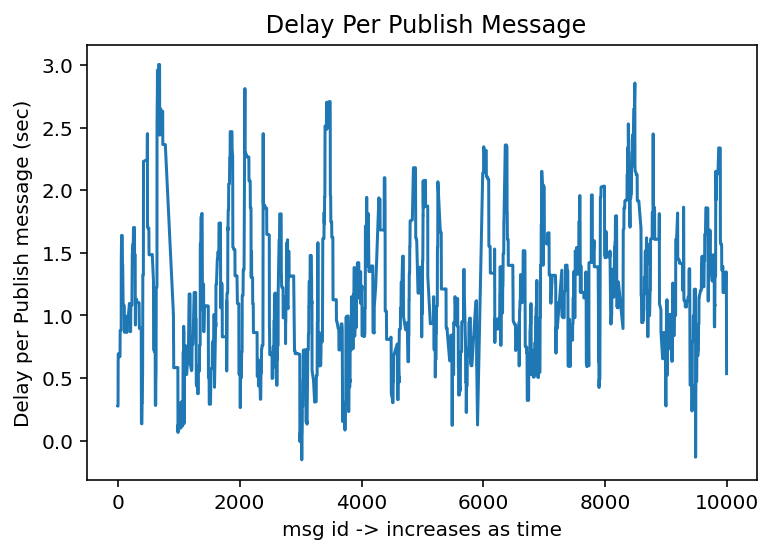

In [251]:
delay_plot_base_name = ""
delay_plot_single(delay_x, delay_y)

In [330]:
"""
@delay_csv_dir: e.g. "../../delay_graph/tc-0/linear_pf/csv/"
@broker_pos: e.g. to compute the msg diff between broker 1 and 7, pass in [0,6]
"""
def display_delay_graph(csv_dir, broker_pos, plot_base_name="", forced_delay_time_offset = -1, scatter = False):
    delay_csv_dir = csv_dir
    delay_files = my_init(delay_csv_dir)
    delay_all_raw_data = parse_num_delay_csv(delay_files)
    delay_all_data = delay_process_all(delay_all_raw_data, broker_pos, broker_pos[-1])
    start_pos = broker_pos[0]
    end_pos = broker_pos[-1]
    reset_find_msg_id_in_dst()
    try:
        delay = compute_src_dst_offset(delay_all_raw_data[start_pos][1], start_pos+1, 
                                               delay_all_raw_data[end_pos][1], end_pos+1)
    except:
        print("[ INFO ] defaultling time offset to 0")
        delay = 0
        # no op
    if(forced_delay_time_offset == -1):
        forced_delay_time_offset = delay
    print("configured forced_delay_time_offset = {}".format(forced_delay_time_offset))
    delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1], forced_delay_time_offset)
    delay_plot_single(delay_x, delay_y, plot_base_name, scatter)
    print("packet loss = {}, packet malformed = {}".format(len(find_msg_id_in_dst.packet_loss), 
                                                           len(find_msg_id_in_dst.packet_malformed)))
    return (find_msg_id_in_dst.packet_loss, find_msg_id_in_dst.packet_malformed)

[../../delay_graph/tc-0/linear_sf/csv/b1.csv] Total no. of rows: 81784
[../../delay_graph/tc-0/linear_sf/csv/b2.csv] Total no. of rows: 40512
[../../delay_graph/tc-0/linear_sf/csv/b3.csv] Total no. of rows: 40330
[../../delay_graph/tc-0/linear_sf/csv/b4.csv] Total no. of rows: 40286
[../../delay_graph/tc-0/linear_sf/csv/b5.csv] Total no. of rows: 39944
[../../delay_graph/tc-0/linear_sf/csv/b6.csv] Total no. of rows: 39799
[../../delay_graph/tc-0/linear_sf/csv/b7.csv] Total no. of rows: 40494
[ LOG ] offset between dst=0.884787 and src=5.291264
configured forced_delay_time_offset = 0
packet loss = 1, packet malformed = 0


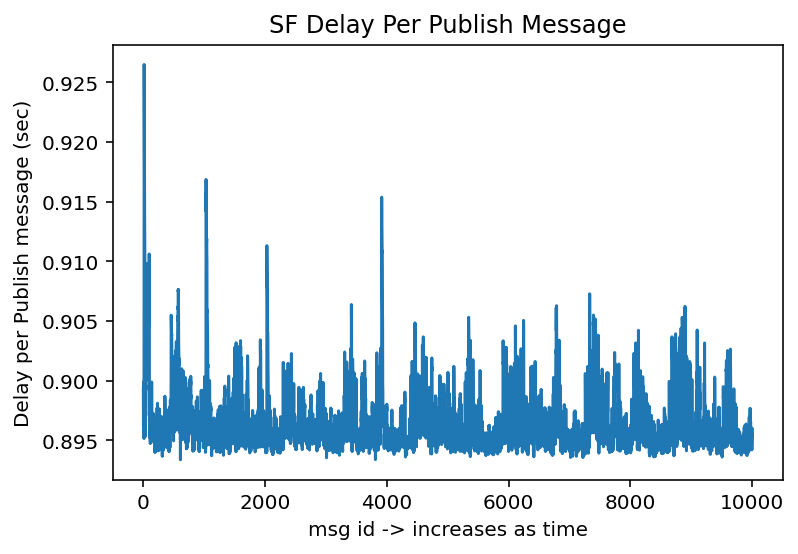

In [334]:
p_loss, p_mal = display_delay_graph("../../delay_graph/tc-0/linear_sf/csv/", [0,6], "SF", 0, False)
# save_plot("delay/delay_plot_sf_tc-0")

experimental area

[../../delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 71301
[../../delay_graph/tc-10/linear_sf/csv/b2.csv] Total no. of rows: 10536
[../../delay_graph/tc-10/linear_sf/csv/b3.csv] Total no. of rows: 11339
[../../delay_graph/tc-10/linear_sf/csv/b4.csv] Total no. of rows: 11156
[../../delay_graph/tc-10/linear_sf/csv/b5.csv] Total no. of rows: 10953
[../../delay_graph/tc-10/linear_sf/csv/b6.csv] Total no. of rows: 10831
[../../delay_graph/tc-10/linear_sf/csv/b7.csv] Total no. of rows: 14204
[ LOG ] offset between dst=0.000332 and src=10.382829
configured forced_delay_time_offset = 15.382496999999999
packet loss = 759, packet malformed = 0


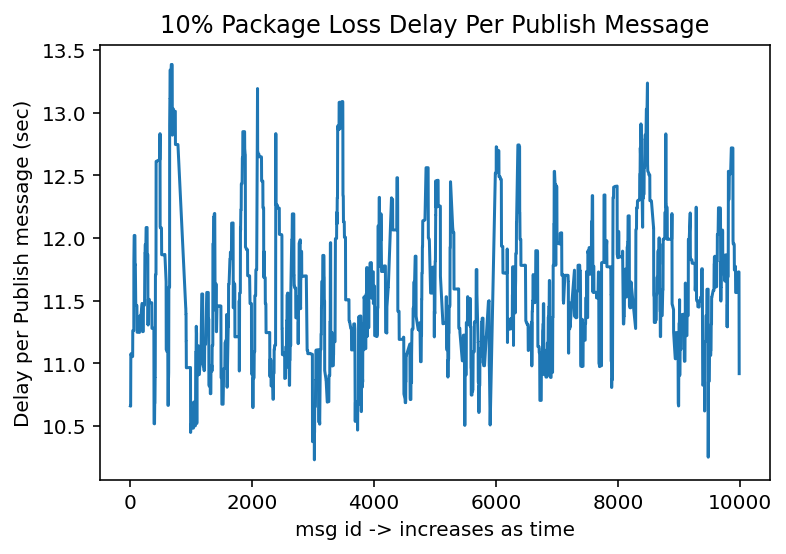

In [333]:
p_loss, p_mal = display_delay_graph("../../delay_graph/tc-10/linear_sf/csv/", [0,6], "10% Package Loss", -1, False)
# save_plot("delay/delay_plot_sf_tc-10")

[../../delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 71301
[../../delay_graph/tc-10/linear_sf/csv/b2.csv] Total no. of rows: 10536
[../../delay_graph/tc-10/linear_sf/csv/b3.csv] Total no. of rows: 11339
[../../delay_graph/tc-10/linear_sf/csv/b4.csv] Total no. of rows: 11156
[../../delay_graph/tc-10/linear_sf/csv/b5.csv] Total no. of rows: 10953
[../../delay_graph/tc-10/linear_sf/csv/b6.csv] Total no. of rows: 10831
[../../delay_graph/tc-10/linear_sf/csv/b7.csv] Total no. of rows: 14204
[ LOG ] offset between dst=0.000332 and src=10.382829
configured forced_delay_time_offset = 15.382496999999999
packet loss = 759, packet malformed = 0


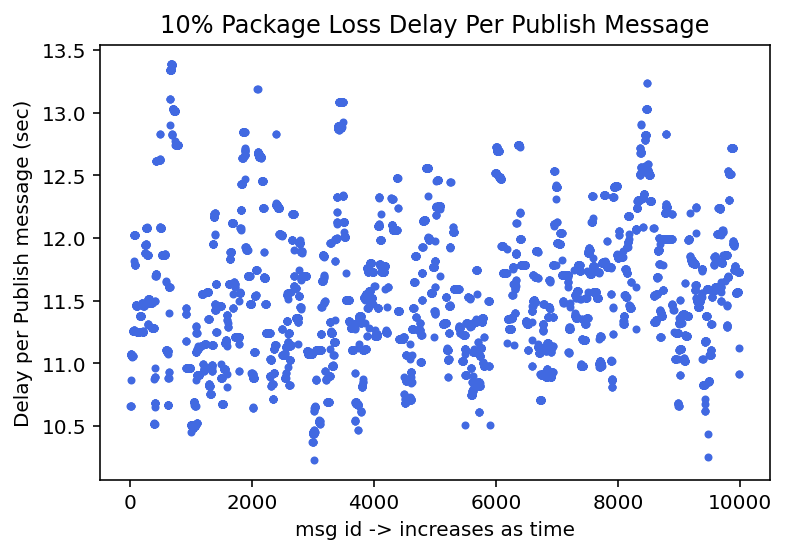

In [335]:
p_loss, p_mal = display_delay_graph("../../delay_graph/tc-10/linear_sf/csv/", [0,6], "10% Package Loss", -1, True)
# save_plot("delay/delay_plot_sf_tc-10_scatter")

[../../delay_graph/tc-25/linear_sf/csv/b1.csv] Total no. of rows: 69919
[../../delay_graph/tc-25/linear_sf/csv/b2.csv] Total no. of rows: 3577
[../../delay_graph/tc-25/linear_sf/csv/b3.csv] Total no. of rows: 2931
[../../delay_graph/tc-25/linear_sf/csv/b4.csv] Total no. of rows: 2615
[../../delay_graph/tc-25/linear_sf/csv/b5.csv] Total no. of rows: 2412
[../../delay_graph/tc-25/linear_sf/csv/b6.csv] Total no. of rows: 2391
[../../delay_graph/tc-25/linear_sf/csv/b7.csv] Total no. of rows: 3015
[ LOG ] offset between dst=0.754977 and src=5.492996
configured forced_delay_time_offset = 9.738019
packet loss = 3767, packet malformed = 2


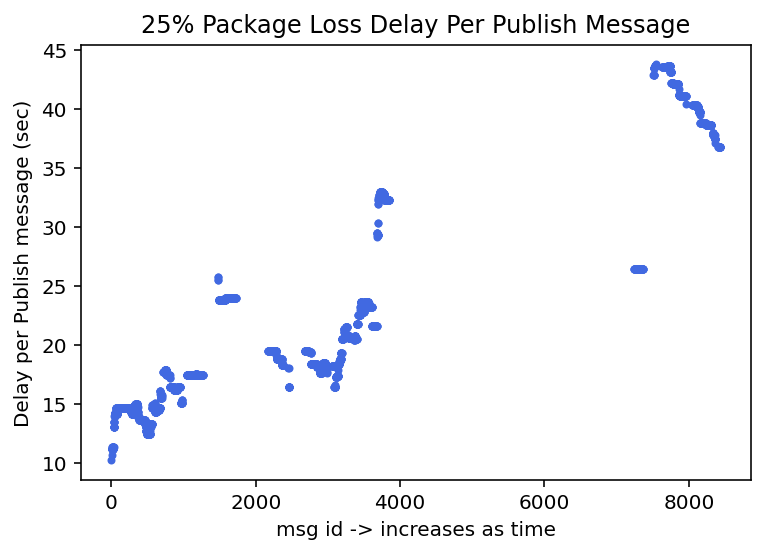

In [336]:
p_loss, p_mal = display_delay_graph("../../delay_graph/tc-25/linear_sf/csv/", [0,6], "25% Package Loss", -1, True)
# save_plot("delay/delay_plot_sf_tc-25_scatter")

[../../delay_graph/tc-25/linear_sf/csv/b1.csv] Total no. of rows: 69919
[../../delay_graph/tc-25/linear_sf/csv/b2.csv] Total no. of rows: 3577
[../../delay_graph/tc-25/linear_sf/csv/b3.csv] Total no. of rows: 2931
[../../delay_graph/tc-25/linear_sf/csv/b4.csv] Total no. of rows: 2615
[../../delay_graph/tc-25/linear_sf/csv/b5.csv] Total no. of rows: 2412
[../../delay_graph/tc-25/linear_sf/csv/b6.csv] Total no. of rows: 2391
[../../delay_graph/tc-25/linear_sf/csv/b7.csv] Total no. of rows: 3015
[ LOG ] offset between dst=0.754977 and src=5.492996
configured forced_delay_time_offset = 9.738019
packet loss = 3767, packet malformed = 2


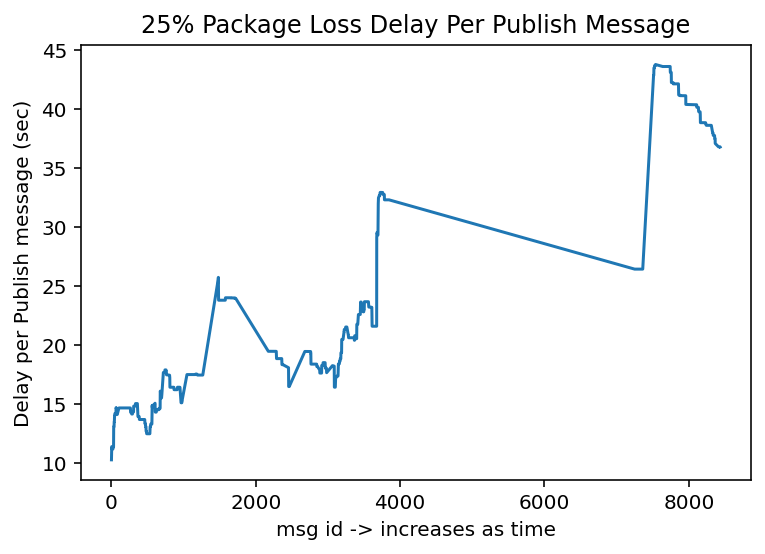

In [337]:
p_loss, p_mal = display_delay_graph("../../delay_graph/tc-25/linear_sf/csv/", [0,6], "25% Package Loss", -1, False)
# save_plot("delay/delay_plot_sf_tc-25")

[../../delay_graph/tc-10/linear_pf/csv/b1.csv] Total no. of rows: 72316
[../../delay_graph/tc-10/linear_pf/csv/b2.csv] Total no. of rows: 11487
[../../delay_graph/tc-10/linear_pf/csv/b3.csv] Total no. of rows: 11222
[../../delay_graph/tc-10/linear_pf/csv/b4.csv] Total no. of rows: 11137
[../../delay_graph/tc-10/linear_pf/csv/b5.csv] Total no. of rows: 11338
[../../delay_graph/tc-10/linear_pf/csv/b6.csv] Total no. of rows: 11484
[../../delay_graph/tc-10/linear_pf/csv/b7.csv] Total no. of rows: 12577
[ LOG ] offset between dst=0.00028 and src=0.000751
configured forced_delay_time_offset = 5.000471
packet loss = 848, packet malformed = 0


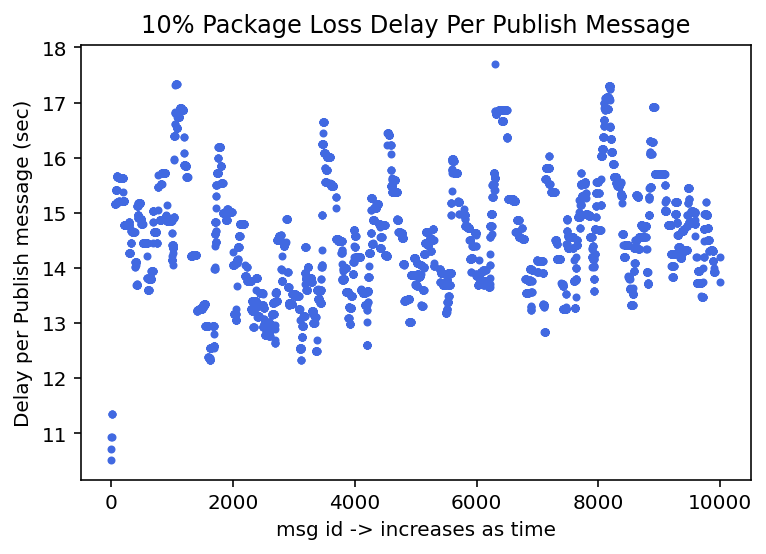

In [338]:
p_loss, p_mal = display_delay_graph("../../delay_graph/tc-10/linear_pf/csv/", [0,6], "10% Package Loss", -1, True)
# save_plot("delay/delay_plot_pf_tc-10")

### Intermediate Delays

In [340]:
# process_single(f_tmp, r_tmp, 1)
# @is_src = 1 means we are interested in broker->broker data. Otherwise, broker->client data
def delay_process_intermediate_single(fields, rows, broker_num, is_src = 1):
    src_filter = [brokers[broker_num]]
    intermediate_dst_filter = clients + brokers[1:broker_num+1] # must look forward
    # print(intermediate_dst_filter, broker_num)
    # process data
    result = my_delay_filter(rows, src_filter, intermediate_dst_filter, 3)
    return result

'''
@all_data: consists of raw data in the form of [ (field, rows) ] 
@selected: specifies which data in @all_data to process, in the form of [ index_1, index_2, ... ] 
@dst_pos: an index which specifies the position of data that is broker->client
    takes in @all_data and processes the selected one specified at @selected
    returns a list of [ (processed_data) ]  for each data of type (field, data) in @all_data
'''
def delay_process_intermediate_all(all_data, selected):
    result = []
    for i in selected:
        fld, data = all_data[i]
        result.append(delay_process_intermediate_single(fld, data, i+1, 1))
    return result

"""
Processes intermediate delays, by looking at the time difference between PUB of two brokers
@delay_csv_dir: e.g. "../../delay_graph/tc-0/linear_pf/csv/"
@broker_pos: e.g. to compute the msg diff between broker 1 and 7, pass in [0,6]
"""
def display_intermediate_delay_graph(csv_dir, broker_pos, plot_base_name="", forced_delay_time_offset = -1, scatter = False):
    delay_csv_dir = csv_dir
    delay_files = my_init(delay_csv_dir)
    delay_all_raw_data = parse_num_delay_csv(delay_files)
    delay_all_data = delay_process_intermediate_all(delay_all_raw_data, broker_pos)
    start_pos = broker_pos[0]
    end_pos = broker_pos[-1]
    reset_find_msg_id_in_dst()
    if(forced_delay_time_offset == -1):
        forced_delay_time_offset = compute_src_dst_offset(delay_all_raw_data[start_pos][1], start_pos+1, 
                                               delay_all_raw_data[end_pos][1], end_pos+1)
    delay_x, delay_y = delay_compute_mgs_delay(delay_all_data[0], delay_all_data[1], forced_delay_time_offset)
    delay_plot_single(delay_x, delay_y, plot_base_name, scatter)
    print("packet loss = {}, packet malformed = {}".format(len(find_msg_id_in_dst.packet_loss), 
                                                           len(find_msg_id_in_dst.packet_malformed)))
    return (find_msg_id_in_dst.packet_loss, find_msg_id_in_dst.packet_malformed)

[../../delay_graph/tc-10/linear_sf/csv/b1.csv] Total no. of rows: 71301
[../../delay_graph/tc-10/linear_sf/csv/b2.csv] Total no. of rows: 10536
[../../delay_graph/tc-10/linear_sf/csv/b3.csv] Total no. of rows: 11339
[../../delay_graph/tc-10/linear_sf/csv/b4.csv] Total no. of rows: 11156
[../../delay_graph/tc-10/linear_sf/csv/b5.csv] Total no. of rows: 10953
[../../delay_graph/tc-10/linear_sf/csv/b6.csv] Total no. of rows: 10831
[../../delay_graph/tc-10/linear_sf/csv/b7.csv] Total no. of rows: 14204
packet loss = 1006, packet malformed = 0


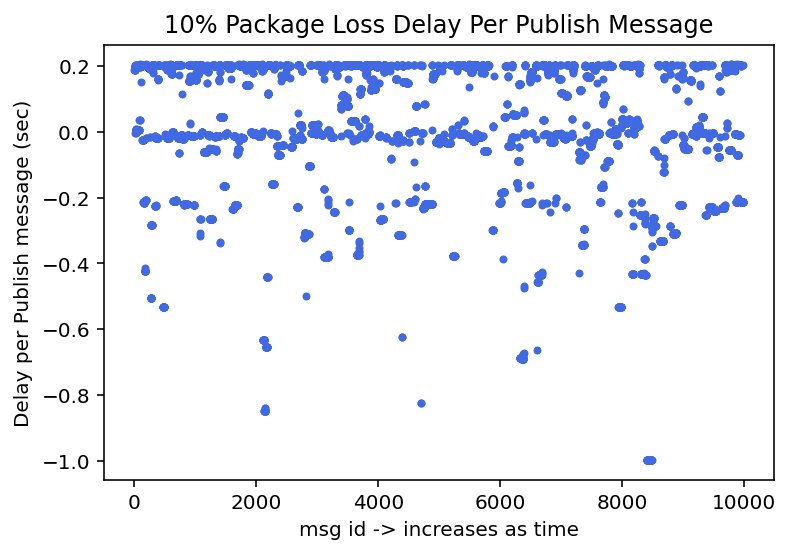

In [341]:
p_loss, p_mal = display_intermediate_delay_graph("../../delay_graph/tc-10/linear_sf/csv/", [1,0], "10% Package Loss", 0, True)

In [342]:
p_loss

{8194,
 4112,
 4113,
 4114,
 4115,
 4116,
 4117,
 4118,
 4119,
 2074,
 2075,
 2076,
 2077,
 2078,
 2079,
 8219,
 2081,
 2082,
 2083,
 2084,
 6184,
 6186,
 6206,
 6207,
 75,
 4187,
 108,
 4210,
 4211,
 4212,
 4213,
 4214,
 4215,
 4216,
 4217,
 4218,
 4219,
 4220,
 4221,
 4222,
 4223,
 4224,
 4225,
 4226,
 4227,
 4228,
 4229,
 6538,
 6539,
 8574,
 4233,
 4234,
 4235,
 4236,
 6540,
 4238,
 4239,
 4240,
 4241,
 4242,
 4243,
 4244,
 4245,
 4246,
 4247,
 4248,
 4249,
 4250,
 4251,
 4252,
 4253,
 4254,
 4255,
 4256,
 4257,
 4258,
 4259,
 4260,
 4261,
 4262,
 4263,
 4264,
 4265,
 6545,
 6546,
 4268,
 4269,
 4270,
 8581,
 2224,
 8582,
 6550,
 8379,
 4285,
 8387,
 8388,
 8389,
 198,
 8390,
 8391,
 8392,
 8393,
 8394,
 8395,
 4303,
 6555,
 7285,
 8594,
 6560,
 6391,
 275,
 2335,
 4384,
 290,
 2339,
 6572,
 4537,
 6573,
 6287,
 4539,
 6574,
 313,
 4409,
 4540,
 6575,
 8505,
 6576,
 4541,
 6577,
 4542,
 6578,
 4543,
 6579,
 4544,
 6580,
 2388,
 4545,
 6581,
 4546,
 6582,
 4547,
 351,
 352,
 6583,
 